In [1]:
import numpy as np
from datetime import datetime
import time
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import pandas as pd
from pandas import DataFrame as df

In [2]:
# plot example cough
train_path = 'Freesound_Audio_Train/'
file = '02d6b747.wav'
sample_rate, samples = wavfile.read(str(train_path) + file)
tr_labels = pd.read_csv('train_labels.csv')
ts_labels = pd.read_csv('test_labels.csv')

In [3]:
samples.shape

(96138,)

In [4]:
"""Log of spectrogram is much cleaner for plotting and is connected to how humans hear.
see https://www.kaggle.com/davids1992/speech-representation-and-data-exploration"""
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [5]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

In [6]:
print(freqs)
print(sample_rate)
print('\n ' + str(len(samples)))
print(sample_rate/len(samples))

[    0.    50.   100.   150.   200.   250.   300.   350.   400.   450.
   500.   550.   600.   650.   700.   750.   800.   850.   900.   950.
  1000.  1050.  1100.  1150.  1200.  1250.  1300.  1350.  1400.  1450.
  1500.  1550.  1600.  1650.  1700.  1750.  1800.  1850.  1900.  1950.
  2000.  2050.  2100.  2150.  2200.  2250.  2300.  2350.  2400.  2450.
  2500.  2550.  2600.  2650.  2700.  2750.  2800.  2850.  2900.  2950.
  3000.  3050.  3100.  3150.  3200.  3250.  3300.  3350.  3400.  3450.
  3500.  3550.  3600.  3650.  3700.  3750.  3800.  3850.  3900.  3950.
  4000.  4050.  4100.  4150.  4200.  4250.  4300.  4350.  4400.  4450.
  4500.  4550.  4600.  4650.  4700.  4750.  4800.  4850.  4900.  4950.
  5000.  5050.  5100.  5150.  5200.  5250.  5300.  5350.  5400.  5450.
  5500.  5550.  5600.  5650.  5700.  5750.  5800.  5850.  5900.  5950.
  6000.  6050.  6100.  6150.  6200.  6250.  6300.  6350.  6400.  6450.
  6500.  6550.  6600.  6650.  6700.  6750.  6800.  6850.  6900.  6950.
  7000

In [7]:
np.linspace(0,sample_rate/len(samples), len(samples)).size

96138

Text(0.5, 0, 'Seconds')

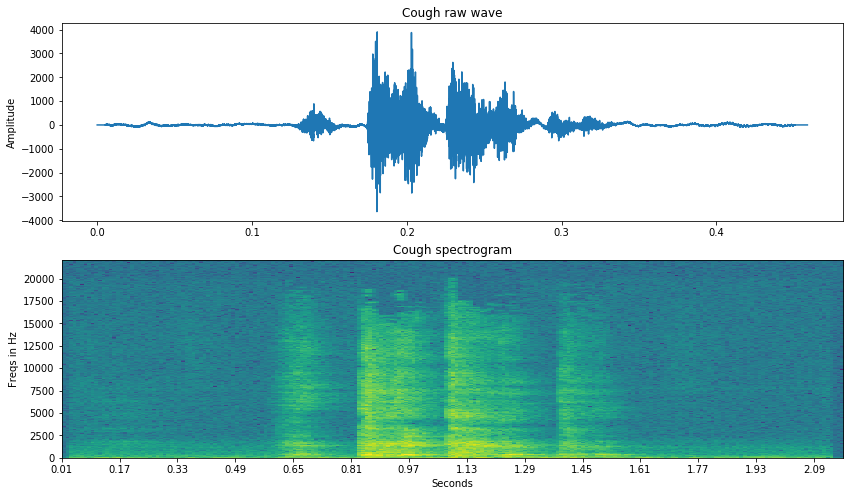

In [8]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title('Cough raw wave')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0,sample_rate/len(samples), len(samples)), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::50])
ax2.set_xticks(times[::16])
ax2.set_title('Cough spectrogram')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [9]:
tr_labels.loc[tr_labels['label'].isin(["Cough"])].head()

,fname,label,manually_verified,freesound_id,license
23,00d1fe46.wav,Cough,0,93029,Creative Commons 0
104,02d6b747.wav,Cough,1,98676,Creative Commons 0
155,047b3d34.wav,Cough,0,180046,Attribution
280,07ec6849.wav,Cough,0,125403,Creative Commons 0
319,09282dc5.wav,Cough,0,9297,Creative Commons 0


# Dataset & Visualizing Classes

In [10]:
import torch
import sys
from torch.utils.data import Dataset, DataLoader
from torchvision import *
from datetime import datetime
from skimage import io, transform
from PIL import Image
#from torchaudio.transforms import MFCC
import librosa
import os
import time
import copy

In [60]:
# turn our freesound dataset into cough, 1, and non-cough, 0 labels
train_labels = pd.read_csv('train_labels.csv')
test_labels = pd.read_csv('test_labels.csv')

In [61]:
print(len(train_labels[train_labels.iloc[:,1] == 'Cough'].index))

243


In [62]:
# train_non_cough_idx = []
# for idx,item in enumerate(train_labels.iloc[:,1].drop_duplicates()):
#     print(item)
#     if idx == 0:
#         train_non_cough_idx = train_labels[train_labels.iloc[:,1] == item].index[:6]
#     if item != 'Cough':
#         np.concatenate(train_non_cough_idx,train_labels[train_labels.iloc[:,1] == item].index[:6])
        
# print(train_non_cough_idx)

In [63]:
# for index, row in df.iterrows():
#     print(train_labels[train_labels.iloc[:,1] != 'Cough'])

TypeError: iterrows() missing 1 required positional argument: 'self'

In [12]:
train_non_cough_idx = train_labels[train_labels.iloc[:,1] != 'Cough'].index
train_cough_idx = train_labels[train_labels.iloc[:,1] == 'Cough'].index
test_non_cough_idx = test_labels[test_labels.iloc[:,1] != 'Cough'].index
test_cough_idx = test_labels[test_labels.iloc[:,1] == 'Cough'].index

In [13]:
len(train_cough_idx)

243

In [14]:
new_train = train_labels.copy()
new_test = test_labels.copy()

In [15]:
new_train.iloc[train_non_cough_idx,1] = 0
new_train.iloc[train_cough_idx,1] = 1
new_test.iloc[test_non_cough_idx,1] = 0
new_test.iloc[test_cough_idx,1] = 1

In [16]:
new_train.to_csv('train_binary_labels.csv', index=False)
new_test.to_csv('test_binary_labels.csv', index=False)

In [17]:
class FreesoundDataset(Dataset):
    def __init__(self, csv_labels, root_dir, transform=None, test=False):
        """
        Args:
            csv_labels: path to labels file
            root_dir: path to file directory
            transform: optional transforms
            test: training vs testing mode
        """
        self.labels = pd.read_csv(csv_labels)
        self.transform = transform
        self.test = test
        
        # root path depends on training vs testing data files
        if self.test:
            self.root = os.path.join(root_dir,'Freesound_Audio_Test')
        else:
            self.root = os.path.join(root_dir,'Freesound_Audio_Train')


    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        # start_time = datetime.now()
        filename = self.labels.iloc[idx,0]
        wave_path = os.path.join(self.root,filename)
        sample_rate, sample = wavfile.read(wave_path)
        
        # clamp all samples to 500,000 frames
        if len(sample) > 500000:
            sample = sample[:500000]
        else:
            l = len(sample)
            temp = np.zeros(500000,dtype='int16')
            temp[0:l] = sample
            sample = temp
        
        if self.transform:
            sample = self.transform(sample)
        # reshape to (3,224,224) for 
        temp = torch.tensor(sample.numpy().reshape(1,1,128,977))
        downsample = torch.nn.functional.interpolate(temp, (224, 224), mode='bilinear')
        temp = np.repeat(downsample[...],3, axis=1)
        sample = temp.squeeze()
        
        normalize = transforms.Compose([transforms.Normalize(mean,std)])
        sample = normalize(sample)
        #print("Time Elapsed Processing WAV: {} seconds".format(
        #(datetime.now() - start_time).total_seconds()))
        
        label = self.labels.iloc[idx,1]
        return sample, label

In [18]:
# std = (0.229 + 0.224 + 0.225) / 3
# mean = (0.485 + 0.456 + 0.406) / 3
std = [0.229, 0.224, 0.225]
mean = [0.485, 0.456, 0.406]
print(mean)
"""Mel-frequency cepstral coefficients form gives us
    approximation of human auditory response.
    This also attempts to remove speaker dependent qualities.
    our sample rate is 44100 after reading the wav files,
    start with 20 mfccs then increase if needed"""
trns = transforms.Compose([
    lambda x: x.astype(np.float32) / np.max(x),
    lambda x: librosa.feature.mfcc(x, sr=44100, n_mfcc=128),
    transforms.ToTensor()
])

[0.485, 0.456, 0.406]


In [19]:
example = FreesoundDataset(csv_labels='train_binary_labels.csv',root_dir='.',transform=trns)

In [20]:
example[0]

//anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(tensor([[[ 2.6154e+02,  2.9200e+02,  1.2695e+02,  ..., -2.3144e+03,
           -2.3212e+03, -2.3359e+03],
          [ 1.9039e+02,  1.6011e+02,  5.2380e+01,  ..., -1.4520e+03,
           -1.4552e+03, -1.4679e+03],
          [ 7.6568e+01, -5.0923e+01, -6.6926e+01,  ..., -7.2118e+01,
           -6.9787e+01, -7.9184e+01],
          ...,
          [ 9.7699e+00,  4.0477e+00, -1.4634e+00,  ..., -3.9907e+00,
           -7.3203e+00, -8.2276e-02],
          [ 4.3810e+00, -3.6112e+00, -2.2273e-01,  ..., -2.3093e+00,
           -7.3517e+00, -2.2037e+00],
          [ 1.0130e+00, -8.3979e+00,  5.5268e-01,  ..., -1.2584e+00,
           -7.3714e+00, -3.5295e+00]],
 
         [[ 2.6750e+02,  2.9865e+02,  1.2991e+02,  ..., -2.3659e+03,
           -2.3728e+03, -2.3879e+03],
          [ 1.9477e+02,  1.6381e+02,  5.3679e+01,  ..., -1.4843e+03,
           -1.4876e+03, -1.5006e+03],
          [ 7.8406e+01, -5.1930e+01, -6.8290e+01,  ..., -7.3598e+01,
           -7.1215e+01, -8.0822e+01],
          ...,
    

In [21]:
# see what our samples look like
#plt.plot(example[0,:,:])

In [22]:
# TESTING CODE
# # reshape spectrograms to fit (3,224,224) size tensor
# print(example.shape)
# temp = torch.tensor(example.numpy().reshape(1,1,128,977))
# print(temp.shape)
# downsample = torch.nn.functional.interpolate(temp, (224, 224), mode='bilinear')
# print(downsample.shape)
# print("downsample \n" + str(downsample.numpy()[0]))
# temp = np.repeat(downsample[...],3, axis=1)
# print(temp.shape)
# print("reshaped \n" + str(temp[0]))
# final = temp.squeeze()
# print(final.shape)

In [23]:
dataloader = DataLoader(FreesoundDataset(csv_labels='train_binary_labels.csv',root_dir='.',transform=trns), batch_size=10, shuffle=True, num_workers=0)

In [24]:
for idx, (sample, label) in enumerate(dataloader):
    print(sample.numpy().shape)
    #plt.imshow(sample.numpy()[0,:,:])
    if idx == 2:
        break

(10, 3, 224, 224)
(10, 3, 224, 224)
(10, 3, 224, 224)


# Build net and preprocess inputs for ResNeXt

In [25]:
import torch.nn as nn
import pretrainedmodels
import torch.optim as optim
from torch.optim import lr_scheduler

In [26]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [27]:
print(pretrainedmodels.pretrained_settings['se_resnext50_32x4d'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'num_classes': 1000}}


In [28]:
# Use AlexNet
import torchvision.models as models
from sampler import ImbalancedDatasetSampler
alexnet = models.alexnet(pretrained=True)

In [31]:
# train on GPU if we can
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

std = [0.229, 0.224, 0.225]
mean = [0.485, 0.456, 0.406]

transform = transforms.Compose([
    lambda x: x.astype(np.float32) / np.max(x),
    lambda x: librosa.feature.mfcc(x, sr=44100, n_mfcc=128),
    transforms.ToTensor() 
    ])
train_data = FreesoundDataset(csv_labels='train_binary_labels.csv',root_dir='.',transform=transform)
test_data = FreesoundDataset(csv_labels='test_binary_labels.csv',root_dir='.',transform=transform, test=True)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True) # drop last batch if not full
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, drop_last=True)

net = alexnet
for param in net.parameters():
    param.requires_grad = False

new_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
        )

net.classifier = new_classifier

net = net.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.classifier.parameters(), lr=0.001, momentum=0.9)
schedule = lr_scheduler.StepLR(optimizer, step_size=10,gamma=0.1)
epochs = 2
BATCH_SIZE = 64
use_cuda = False

In [32]:
# ReNeXt Attempt
# # train on GPU if we can
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# std = pretrainedmodels.pretrained_settings['se_resnext50_32x4d']["imagenet"]['std']
# mean = pretrainedmodels.pretrained_settings['se_resnext50_32x4d']["imagenet"]['mean']

# transform = transforms.Compose([
#     lambda x: x.astype(np.float32) / np.max(x),
#     lambda x: librosa.feature.mfcc(x, sr=44100, n_mfcc=128),
#     transforms.ToTensor() 
#     ])

# train_dataloader = DataLoader(FreesoundDataset(csv_labels='train_binary_labels.csv',root_dir='.',transform=transform), batch_size=64, shuffle=True, drop_last=True) # drop last batch if not full

# resnext = 'se_resnext50_32x4d'
# net = pretrainedmodels.__dict__[resnext](num_classes=1000,pretrained='imagenet')
# for param in net.parameters():
#     param.requires_grad = False
# num_ftrs = net.last_linear.in_features
# net.last_linear = nn.Linear(num_ftrs, 2)
# net = net.to(device)
# criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(net.last_linear.parameters(), lr=0.001, momentum=0.9)
# schedule = lr_scheduler.StepLR(optimizer, step_size=10,gamma=0.1)
# epochs = 3 
# BATCH_SIZE = 64
# use_cuda = False

# Train

In [33]:
def model_train(net, inputs, labels, criterion, optimizer):
    """
        net        network used to train
        inputs     (torch Tensor) batch of input images
        labels     (torch Tensor) ground truth labels
        criterion   loss function
        optimizer  used in backward pass

    Returns:
        running_loss    (float) loss from this batch of images
        num_correct     (torch Tensor, size 1) number of inputs
                        in this batch predicted correctly
        total_images    (float or int) total number of images in this batch
    """
    optimizer.zero_grad()
    
    with torch.set_grad_enabled(True):
        outputs = net(inputs)
        loss = criterion(outputs, labels.squeeze())
    
    # back pass
    loss.backward()
    optimizer.step()

    _, index_out = outputs.max(1)
    running_loss = loss.item()
    num_correct = sum(index_out.squeeze() == labels.squeeze()).item()
    total_images = inputs.size(0)

    return running_loss, num_correct, total_images

In [34]:
# Check the params of our net
# !pip install torchsummary
# from torchsummary import summary
# summary(net, input_size=(2,64, 3, 224, 224))

In [35]:
def log_progress(curr_batch, batch_size, curr_epoch, total_epochs, dataloader):
    """
    Prints message logging progress through training.
    """
    progress = float(curr_batch + 1)/(float(len(dataloader.dataset)) / batch_size)
    log = "EPOCH [{}/{}].Progress: {} % ".format(
        curr_epoch + 1, total_epochs, round(progress * 100, 2))
    sys.stdout.write("\r" + log)
    sys.stdout.flush()

In [36]:
# # test dataloader
# for batch_num, (test_inputs, test_labels) in enumerate(test_dataloader):
#     print("batch_num = " + str(batch_num))
#     print("label = " + str(test_labels))
#     print(test_inputs)
#     break

In [37]:
train_loss_history = np.zeros(epochs)
train_acc_history  = np.zeros(epochs)
val_loss_history   = np.zeros(epochs)
val_acc_history    = np.zeros(epochs)

start_time = datetime.now()

for epoch in range(epochs):

    # TRAINING ###
    print("Training...")
    net.train()
    
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0

    for batch_num, (inputs, labels) in enumerate(train_dataloader):
        #print(labels)
        log_progress(batch_num, BATCH_SIZE, epoch, epochs, train_dataloader)

        if use_cuda and torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        assert inputs.shape == (64,3,224,224), inputs.shape
        curr_loss, curr_correct, curr_images = model_train(net, inputs, labels, criterion, optimizer)
        running_loss += curr_loss
        num_correct += curr_correct
        total_images += curr_images

    # Update statistics for epoch
    train_loss_history[epoch] = running_loss / total_images
    train_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("\n Train Avg. Loss: [{}] Acc: {} on {} images\n".format(
          round(train_loss_history[epoch],4), train_acc_history[epoch], total_images) )
    
    # VALIDATION ###

    print("Validating...")
    net.eval()
    
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0
    
    for batch_num, (test_inputs, test_labels) in enumerate(test_dataloader):
        
        if use_cuda and torch.cuda.is_available():
            test_inputs = test_inputs.cuda()
            test_labels = test_labels.cuda()

        # Forward pass
        outputs  = net(test_inputs)
                                                 
        loss     = criterion(outputs, test_labels.squeeze())
                                                 
        # Prediction is index with highest class score
        _, preds = torch.max(outputs, 1)
        
        # move data back for analysis
        if use_cuda and torch.cuda.is_available():
            test_labels = test_labels.cpu()
            preds = preds.cpu()

        running_loss  += loss.item()
        num_correct   += torch.sum(preds == test_labels.data.reshape(-1))

        total_images  += test_labels.data.numpy().size
        
    # Update stats for validation data
    val_loss_history[epoch] = running_loss / total_images
    val_acc_history[epoch]  = float(num_correct)  / float(total_images) 
    print("Val Avg. Loss: [{}] Acc: {} on {} images\n".format(
        round(val_loss_history[epoch],4), val_acc_history[epoch], total_images))
    
print("Time Elapsed: {} seconds".format(
    (datetime.now() - start_time).total_seconds()))

Training...
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
EPOCH [1/2].Progress: 0.68 % tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
EPOCH [1/2].Progress: 1.35 % tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
EPOCH [1/2].Progress: 2.03 % tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
EPOCH [1/2].Progress: 2.7 % tenso

KeyboardInterrupt: 

In [ ]:
cough_net = net

In [ ]:
# find ten cough examples


In [ ]:
cough_net()

In [ ]:
train_non_cough_idx = train_labels[train_labels.iloc[:,1] != 'Cough'].index
train_cough_idx = train_labels[train_labels.iloc[:,1] == 'Cough'].index

In [ ]:
train = FreesoundDataset(csv_labels='train_binary_labels.csv',root_dir='.',transform=transform)

In [ ]:
true_pos = 0
false_neg = 0
for idx in train_cough_idx[:10]:
    
    train[0]

In [ ]:
cough_net.eval()
cough_net(train[0][0].unsqueeze(0))

In [ ]:
(train[0][0].reshape(np.newaxis,...)).shape

In [ ]:
train[0][0].unsqueeze(0).shape

In [ ]:
for batch_num, (test_inputs, test_labels) in enumerate(test_dataloader):
    if use_cuda and torch.cuda.is_available():
            test_inputs = test_inputs.cuda()
            test_labels = test_labels.cuda()

    # Forward pass
    outputs  = net(test_inputs)
                                                 
    loss     = criterion(outputs, test_labels.squeeze())
                                                 
    # Prediction is index with highest class score
    _, preds = torch.max(outputs, 1)
    print("predictions = " + str(preds))
    print("labels = " + str(test_labels))

In [ ]:
train[23][1]

In [ ]:
import pyaudio

In [ ]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = 'output.wav'
p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)
print("* recording")
frames = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
print("* done recording")
stream.stop_stream()
stream.close()
p.terminate()
wf = wave.open('C:\\Users\\jack1\\Anaconda3\\Lib\\site-packages\\pocketsphinx\\data\\' + WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()